###### Exercise in Photogrammetry I
## **Ex.7 : Corresponding Points and Förstner Operator**
### Hand out: xx.xx.xxxx
### Submission: xx.xx.xxxx 
### Points: 25

## A. Corresponding Points

You are given two images. We would like to extract corresponding points from both images which could later be used  e.g. for image alignment, 3D reconstruction, or camera calibration. 

**Tasks:**
1. Load the images ```'images/beach1.png'``` and ```'images/beach2.png'```, convert it to float, and visualize both images. (1 Point)
2. Extract the corners for each image with the 'Förstner-Operator' and visualize the results. **Hint:** you can use the functions ```corner_foerstner(...)``` and ```corner_peaks(...)``` from scikit: [example](https://scikit-image.org/docs/stable/api/skimage.feature.html#corner-foerstner). Use the following parameters:
```accuracy_thresh = 0.6; roundness_thresh = 0.0
```
. (6 Points)
3. Compute the cross-correlation between each corner from the first image to each corner of the second image. Use the 13x13 neighborhoods for computing the cross-correlation. Make sure that each corner has a well defined neighborhood (you can delete the others beforehand). The result should be a matrix $C \in R^{nxm}$ where ```C[i,j]``` is the cross-correlation between the *i'th* corner from the first image to the *j'th* corner from the second image. (10 Points)
4. Visualize for each corner of the first image the best corresponding corner in the second image. (4 Points)

**Hint:** Write functions. It makes the code more readable and intuitive. 

## B. Förstner Operator
1. Describe the ellipsoid of the covariance matrix which gets computed in the corner extraction method from Förstner for the following points (2 Points):
   1. a corner point.
   2. a point on a vertical edge 
   3. a point on a horizontal edge
   4. a point in a homogenous area
2. How is the shape/ size of the covariance ellipsoid affecting the matching accuracy? (2 Point)

In [1]:
%matplotlib inline
import skimage.io
from skimage import io, img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt

[]

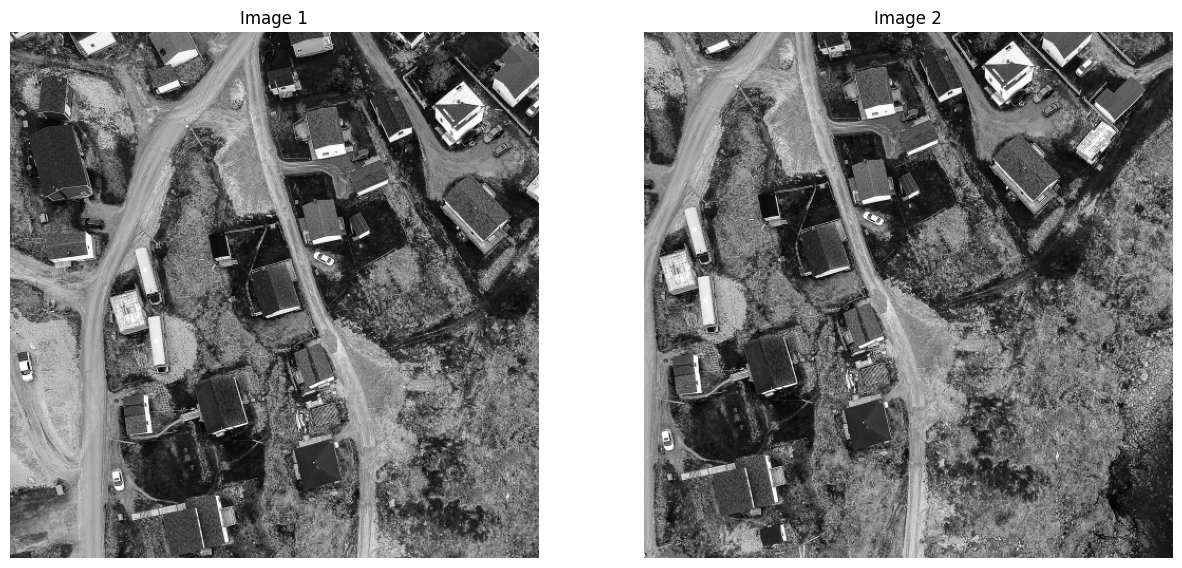

In [2]:
image1 = io.imread('images/beach1.png', as_gray=True)
image2 = io.imread('images/beach2.png', as_gray=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

axs[0].imshow(image1, cmap='gray')
axs[0].set_title('Image 1')
axs[0].axis('off')

axs[1].imshow(image2, cmap='gray')
axs[1].set_title('Image 2')
axs[1].axis('off')

plt.plot()

In [3]:
from skimage.feature import corner_foerstner, corner_peaks

w_image1, q_image1 = corner_foerstner(image1)
w_image2, q_image2 = corner_foerstner(image2)

accuracy_thresh = 0.4
roundness_thresh = 0.3
dist = 50

foerstner_image1 = (q_image1 > roundness_thresh) * (w_image1 > accuracy_thresh) * w_image1
foerstner_image2 = (q_image2 > roundness_thresh) * (w_image2 > accuracy_thresh) * w_image2

corners_image1 = corner_peaks(foerstner_image1, min_distance=dist)
corners_image2 = corner_peaks(foerstner_image2, min_distance=dist)

[]

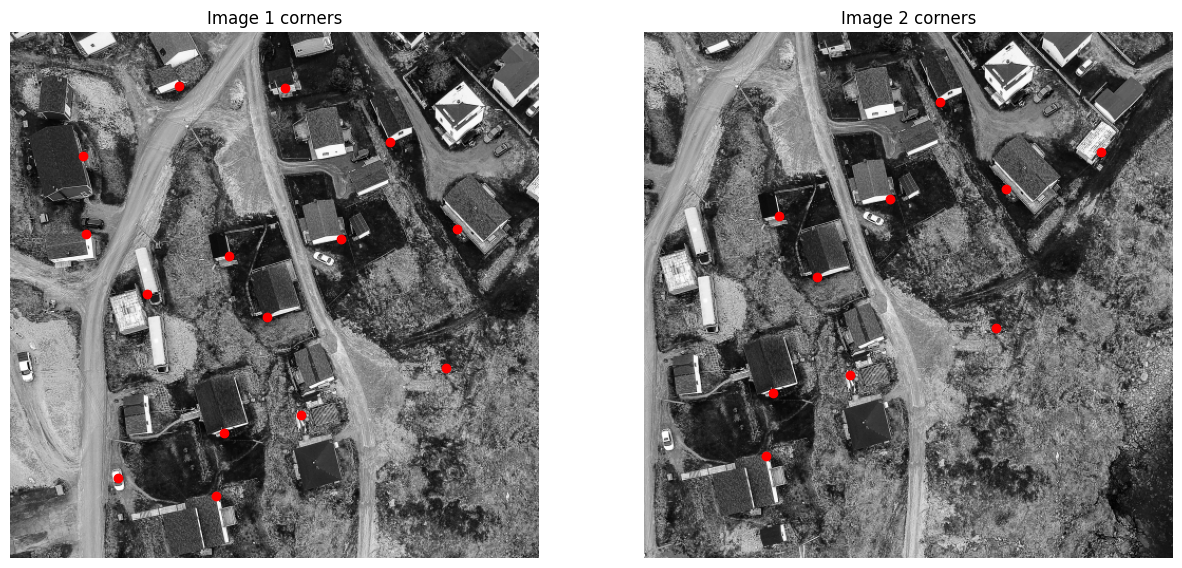

In [4]:
image1 = io.imread('images/beach1.png', as_gray=True)
image2 = io.imread('images/beach2.png', as_gray=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

y_coords_image1, x_coords_image1 = zip(*corners_image1)
axs[0].imshow(image1, cmap='gray')
axs[0].set_title('Image 1 corners')
axs[0].axis('off')
axs[0].scatter(x_coords_image1, y_coords_image1, color='red')

y_coords_image2, x_coords_image2 = zip(*corners_image2)
axs[1].imshow(image2, cmap='gray')
axs[1].set_title('Image 2 corners')
axs[1].axis('off')
axs[1].scatter(x_coords_image2, y_coords_image2, color='red')

plt.plot()

In [25]:
def get_neighborhood(image: np.ndarray, pivot: tuple[int, int], neighborhood_size: int) -> (np.ndarray, bool):
    '''
    Returns neighborhood of a pivot in given image with given size.

    Parameters:
    - image (np.ndarray): Image.
    - pivot (tuple[int, int]): Pivot.
    - neighborhood_size (int): Size of neighborhood.

    Returns:
    - tuple[np.ndarray, bool]: A tuple containing the neighborhood patch and a boolean indicating if the neighborhood is well defined.
    '''
    
    min_vertical = max(0, pivot[0] - (neighborhood_size // 2))
    max_vertical = min(image.shape[0] - 1, pivot[0] + (neighborhood_size / 2))
    min_horizontal = max(0, pivot[1] - (neighborhood_size // 2))
    max_horizontal = min(image.shape[1] - 1, pivot[1] + (neighborhood_size / 2))

    patch = image[int(min_vertical) : int(max_vertical) + 1, int(min_horizontal) : int(max_horizontal) + 1]

    if patch.shape == (neighborhood_size, neighborhood_size):
        return patch, 1
    else:
        return np.array([]), 0

def normalize(image: np.ndarray) -> np.ndarray:
    '''
    Performs normalization of given image.

    Parameters:
    - image (np.ndarray): Image.

     Returns:
    - np.ndarray: Normalized image.
    '''

    # Normalize patches.
    mean_image = np.mean(image)
    std_dev_image = np.std(image)

    image_normalized = (image - mean_image) / std_dev_image

    return image_normalized

def find_cross_correlation_value(image1: np.ndarray, pivot1: tuple[int, int], image2: np.ndarray, pivot2: tuple[int, int], neighborhood_size: int) -> float:
    '''
    Calculates cross-corelation given two images and their respective pivots, with neighborhood size.

    Parameters:
    - image1 (np.ndarray): First image.
    - image2 (np.ndarray): Second image.
    - pivot1 (tuple[int, int]): Pivot to compare of the first image.
    - pivot2 (tuple[int, int]): Pivot to compare of the second image.
    - neighborhood_size (int): Neighborhood size to look at for cross-correlation.

    Returns:
    - int: Cross correlation value at given pivots.
    '''

    # Get well defined neighborhoods.
    patch1, well_defined1 = get_neighborhood(image1, pivot1, neighborhood_size)
    patch2, well_defined2 = get_neighborhood(image2, pivot2, neighborhood_size)        

    # Both have to be well defined.
    if well_defined1 == 1 and well_defined2 == 1:

        # Normalize both patches.
        patch1_norm = normalize(patch1)
        patch2_norm = normalize(patch2)

        # Covariance of g1 and g2 (numerator).
        covariance = np.sum((patch1_norm - np.mean(patch1_norm)) * (patch2_norm - np.mean(patch2_norm)))
        covariance /= (neighborhood_size * neighborhood_size - 1)  # Calculate the covariance.
    
        # Calculate the denominator.
    
        # Normalized Cross Correlation.
        # https://www.youtube.com/watch?v=5YAA7vS6kVU&t=1s 23:39
    
        denominator = np.std(patch1_norm) * np.std(patch2_norm)    

        if denominator != 0.0:
            return (covariance / denominator)
        else:
            return 0.0       
            
    
    else:
        return 0.0

In [35]:
correlation_matrix = np.zeros((corners_image1.shape[0], corners_image2.shape[0]))

for i in range(len(corners_image1)):
    for j in range(len(corners_image2)):
        correlation_matrix[i, j] = find_cross_correlation_value(image1, tuple(corners_image1[i]), image2, tuple(corners_image2[j]), 13)

max_indices = np.argmax(correlation_matrix, axis=1)  # Indices of max values for each row.

paired_values = [(i, max_indices[i]) for i in range(len(max_indices))]

print("Paired best:", paired_values)

Paired best: [(0, 0), (1, 1), (2, 3), (3, 4), (4, 5), (5, 3), (6, 6), (7, 6), (8, 7), (9, 1), (10, 8), (11, 3), (12, 9), (13, 9), (14, 0)]


[]

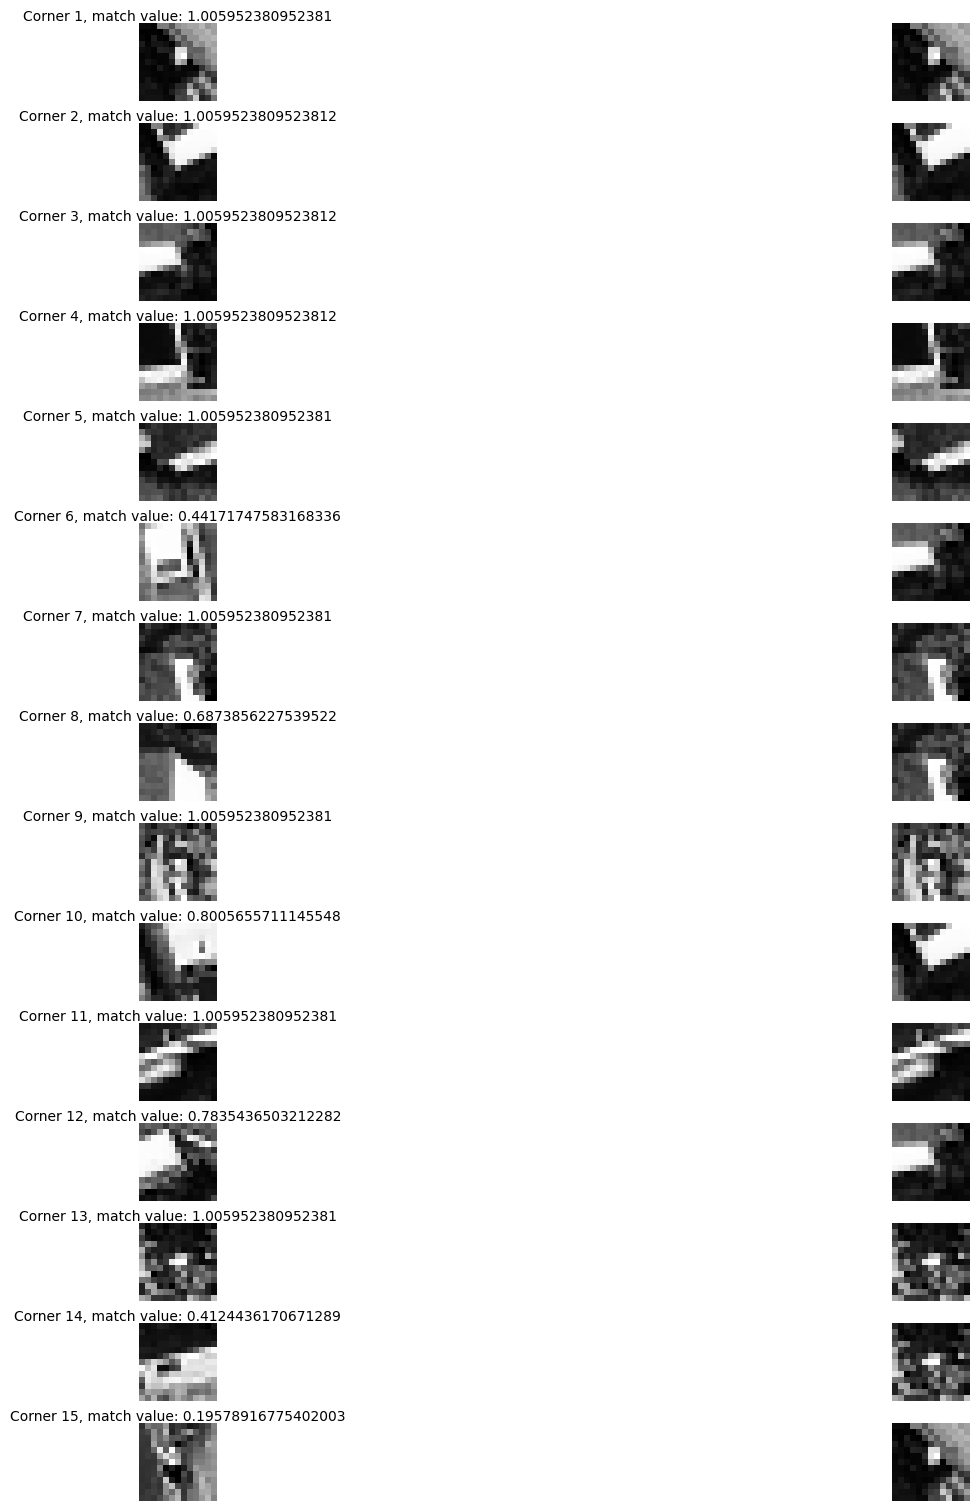

In [36]:
matching_corners = np.empty((0,), dtype=np.dtype([('array1', np.ndarray), ('array2', np.ndarray)]))

for pair_index in range(len(paired_values)):

    corner1, well_defined1 = get_neighborhood(image1, tuple(corners_image1[paired_values[pair_index][0]]), 13)
    corner2, well_defined2 = get_neighborhood(image2, tuple(corners_image2[paired_values[pair_index][1]]), 13)

    if well_defined1 and well_defined2:
        matching_corners = np.append(matching_corners, np.array([(corner1, corner2)], dtype=matching_corners.dtype))

fig, axs = plt.subplots(matching_corners.shape[0], 2, figsize=(15, 15), constrained_layout=True)

for i in range(axs.shape[0]):
    ax = axs[i]
    
    ax[0].imshow(matching_corners[i][0], cmap='gray')
    ax[1].imshow(matching_corners[i][1], cmap='gray')

    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].set_title(f'Corner {i + 1}, match value: {correlation_matrix[paired_values[i]]}', fontsize=10, pad=2)
    #ax[1].set_title('Image 2', fontsize=10, pad=2)
    
plt.plot()

B. Förstner Operator
Describe the ellipsoid of the covariance matrix which gets computed in the corner extraction method from Förstner for the following points (2 Points):
a corner point.
a point on a vertical edge
a point on a horizontal edge
a point in a homogenous area
How is the shape/ size of the covariance ellipsoid affecting the matching accuracy? (2 Point)

1. At a corner, the ellipsoid remains spherical, but grows.
2. Vertical edge makes the ellipsoid elongated along the vertical edge
3. Horizontal edge makes the ellipsoid elongated along the horizontal edge
4. Homogenous area makes the ellipsoid remain spherical without growth.